# NLP Final Term Project <br>
 Name: Vishal Bhashyaam <br><br>
 Email: vishalbarizona.edu

## Import required packages for Project

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import unidecode

# For reproducing the same results

np.random.seed(42)





# Load the data
train_data = pd.read_csv('..\\data\\train.csv')
test_data = pd.read_csv('..\\data\\test.csv')









In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

print(train_data.describe())
print(train_data.groupby('LABEL').size())

# Visualization for better understanding

print("Task Description: The task involves classifying text data into multiple categories.")
print("Number of classes:", train_data['LABEL'].nunique())
print("Dataset size:", train_data.shape[0])

                 ID         LABEL
count  7.031700e+04  70317.000000
mean   9.237206e+18      0.813687
std    5.341639e+18      0.831365
min    5.764730e+14      0.000000
25%    4.592511e+18      0.000000
50%    9.273194e+18      1.000000
75%    1.387591e+19      2.000000
max    1.844662e+19      2.000000
LABEL
0    32071
1    19276
2    18970
dtype: int64
Task Description: The task involves classifying text data into multiple categories.
Number of classes: 3
Dataset size: 70317


In [3]:
"""sns.countplot(train_data['LABEL'])
plt.title('Label Distribution')
plt.show()"""

# This code block takes a long time to run. Optional to run

"sns.countplot(train_data['LABEL'])\nplt.title('Label Distribution')\nplt.show()"

## Measure of Diversity

In [41]:

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
import math

data = train_data

def analyze_text(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    num_sentences = len(sentences)
    num_words = len(words)
    word_types = len(set(words))
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    avg_sentence_length = np.mean(sentence_lengths) if num_sentences > 0 else 0
    lexical_richness = word_types / num_words if num_words > 0 else 0
    return num_sentences, avg_sentence_length, lexical_richness

# Apply the analysis function to each text entry
analysis_results = data['TEXT'].apply(analyze_text)
data[['num_sentences', 'avg_sentence_length', 'lexical_richness']] = pd.DataFrame(analysis_results.tolist(), index=data.index)



In [42]:
category_analysis = data.groupby('LABEL').agg({
    'avg_sentence_length': 'mean',
    'lexical_richness': 'mean',
}).reset_index()

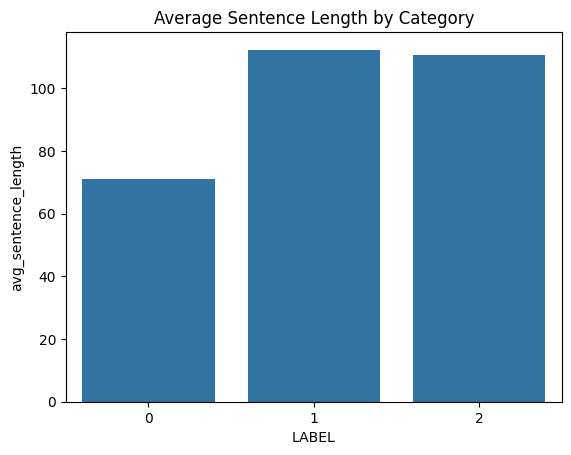

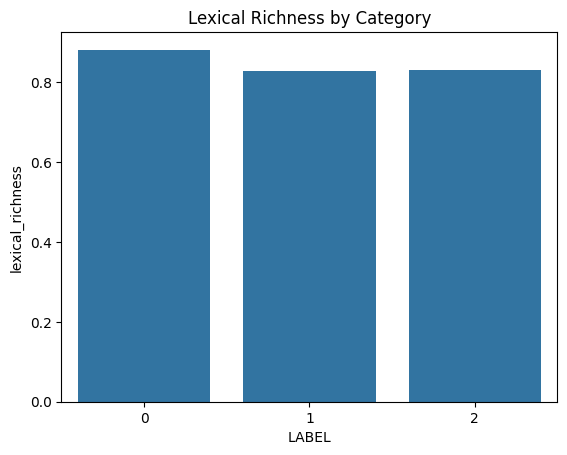

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x='LABEL', y='avg_sentence_length', data=category_analysis)
plt.title('Average Sentence Length by Category')
plt.show()

sns.barplot(x='LABEL', y='lexical_richness', data=category_analysis)
plt.title('Lexical Richness by Category')
plt.show()



In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Text Preprocessing

In [5]:
# Custom stopwords
custom_stopwords = set(stopwords.words('english'))  # Add or remove words here

# Text preprocessing function

# Applying text preprocessing
def preprocess_text(text):
    if pd.isnull(text):
        text = "missingtext"  # Placeholder for missing text
    text = unidecode.unidecode(text)  # Convert accented characters to ASCII
    text = str(text)
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "cannot", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in custom_stopwords])
    return text

In [18]:
def my_preprocess(text):
    if pd.isnull(text):
        text = " "  # Replace NaN with empty space
    text = str(text)  # Ensure text is treated as a string
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords.words('english')])
    return text

## Vectorization using TF-IDF and Data Splitting (Train and Validation)

In [20]:
train_data['TEXT'] = train_data['TEXT'].apply(my_preprocess)
test_data['TEXT'] = test_data['TEXT'].apply(my_preprocess)

# Data vectorization with trigrams
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_train = vectorizer.fit_transform(train_data['TEXT'])
y_train = train_data['LABEL']
X_test = vectorizer.transform(test_data['TEXT'])

# Splitting the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## Training the Modle using Logistic Regression (Custom parameters)

In [21]:
# Training the Logistic Regression model with hyperparameter tuning
params = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), params, cv=3)
grid_search.fit(X_train_split, y_train_split)
best_lr_model = grid_search.best_estimator_

# Model evaluation
y_val_pred_lr = best_lr_model.predict(X_val_split)
print("Logistic Regression Classification Report:")
print(classification_report(y_val_split, y_val_pred_lr))




Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6454
           1       0.88      0.86      0.87      3856
           2       0.89      0.86      0.88      3754

    accuracy                           0.92     14064
   macro avg       0.91      0.90      0.91     14064
weighted avg       0.92      0.92      0.92     14064



## Training the Model using Random Forest Classifier (Custom parameters)

In [22]:
# Comparing with Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_split, y_train_split)
y_val_pred_rf = rf_model.predict(X_val_split)
print("Random Forest Classification Report:")
print(classification_report(y_val_split, y_val_pred_rf))



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6454
           1       0.80      0.83      0.82      3856
           2       0.85      0.76      0.80      3754

    accuracy                           0.89     14064
   macro avg       0.87      0.86      0.86     14064
weighted avg       0.89      0.89      0.88     14064



## Predicting the test data for Kaggle Competition

In [23]:
# Predicting labels for the test dataset using the best model
y_test_pred = best_lr_model.predict(X_test)


## Some Statistical Analysis of the Test Results

In [51]:
from sklearn.model_selection import cross_val_score

# Logistic Regression cross-validation
cv_scores_lr = cross_val_score(best_lr_model, X_test, y_test_pred, cv=5)

# Random Forest cross-validation
cv_scores_rf = cross_val_score(rf_model, X_test, y_test_pred, cv=5)

print(f"Logistic Regression CV Scores: {cv_scores_lr}")
print(f"Random Forest CV Scores: {cv_scores_rf}")


Logistic Regression CV Scores: [0.94510808 0.9576223  0.95250284 0.95022753 0.95079636]
Random Forest CV Scores: [0.89590444 0.89789534 0.90443686 0.89732651 0.89704209]


## Visualize the confusion matrix for train data test results 

[[6374   47   33]
 [ 159 3327  370]
 [  99  414 3241]]


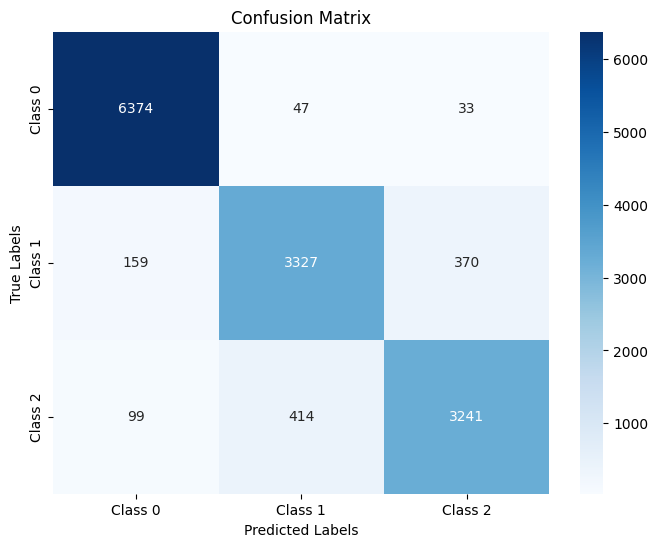

In [26]:
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val_split, y_val_pred_lr)

print(cm)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Error Analysis

In [48]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision = precision_score(y_val_split, y_val_pred_lr,average="macro")

recall = recall_score(y_val_split, y_val_pred_lr,average="macro")
recall = accuracy_score(y_val_split, y_val_pred_lr)

print ("Recall score for Logistic Regression model: ",round(recall*100,3),"%")
print ("Precision score for Logistic Regression model: ",round(precision*100,3),"%")


Recall score for Logistic Regression model:  92.022 %
Precision score for Logistic Regression model:  90.96 %
Accuracy score for Logistic Regression model:  <function accuracy_score at 0x0000025B5F574FE0> %


## Output the Reults to the submission.csv

In [25]:
# Preparing the results for output
My_result = pd.DataFrame({
    "ID": test_data['ID'],
    "LABEL": y_test_pred
})

# Save the results to a CSV file
My_result.to_csv('submission.csv', index=False)